In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes

In [16]:
!pip install GPy
!pip install GPyOpt

     |████████████████████████████████| 1.0MB 7.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633951 sha256=b7a96cd0d4ab30683e6ac277ad8563abcdc51ae9e9a9185b1c0e3f8ebfdacdba
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=ef081b12f7ebf01ab954e63ab057c6ac1e17802d2d8a9c9852df5e2fc4e34aab
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz
     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83623 sha256=aa7122a04f2e879ef6fd0d650fd47c1b93b931c312a050ab9cfadce4e5fafc93
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
Successfully built GPyOpt


In [0]:
X, y = load_diabetes(return_X_y=True)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features=['auto','sqrt','log2']

In [31]:
# Random Search
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               }
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]}


In [32]:
# The base model
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, scoring='neg_mean_squared_error', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
random_result = rf_random.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.0min finished


In [33]:
# Grid search
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf,
        param_grid= {
            'max_depth': [80, 90, 100, 110],
            'n_estimators': [100, 200, 300, 1000],
            'max_features' : [2, 3],
        },scoring='neg_mean_squared_error',
        cv = 3, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   52.5s finished


In [0]:
# Bayesian Optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

def L(props):
    # props = props[0]
    rf = RandomForestRegressor(max_depth = int(props[0][2]), n_estimators = int(props[0][0]), max_features = int(props[0][1]) )
    rf.fit(X,y)
    score = cross_val_score(rf, X,y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

bds = [
       {'name': 'n_estimators', 'type': 'discrete', 'domain': (100, 200, 300, 1000)},
       {'name': 'max_features', 'type': 'discrete', 'domain': (2, 3) },
       {'name': 'max_depth',    'type': 'discrete', 'domain': (80, 90, 100, 110) }
       ]

optimizer = BayesianOptimization(f=L, model_type='GP', acquisition_type='EI', domain=bds, maximize=True)
optimizer.run_optimization(max_iter=10)

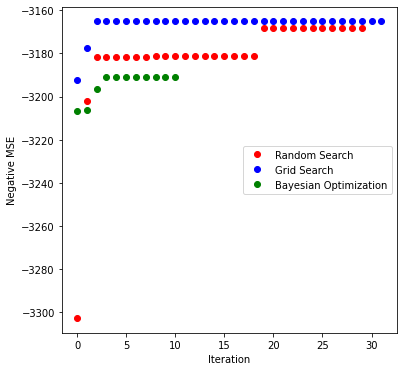

In [35]:
y_rs = np.maximum.accumulate(rf_random.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(grid_search.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
plt.figure(figsize=(6,6))
plt.plot(y_rs, 'ro', label='Random Search')
plt.plot(y_gs, 'bo', label='Grid Search')
plt.plot(y_bo, 'go', label='Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='right');